<font size = '5'>**Разработка модели предсказания популярности поста. Продолжение.** </font>

В данной тетрадке продолжим разбирать принципы, на которых строится популярность того или иного поста. В предыдущей работе мы выяснили, какие слова влияют на популярность поста, о чем стоит писать и на какие темы. Сейчас выясним как иные метрики текста, такие как длина слов, предложения, знаки и проч. влияют на популярность постов.

# Извлекаем из текста необходимые признаки

In [1]:
#!pip install spacy
#!pip install emoji
#!python -m spacy download ru_core_news_md

In [2]:
import pandas as pd
import numpy as np
import phik
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import pymorphy2
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_ru')

import spacy
import emoji
spacy.load('ru_core_news_md')

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import confusion_matrix

import optuna
from optuna.samplers import TPESampler

import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200
RANDOM_STATE = 42
sampler = TPESampler(seed=42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Генадий\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Генадий\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\Генадий\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!


In [3]:
vk = pd.read_csv('D:/vk/new_data/vk.csv')
vk = vk.drop('Unnamed: 1', axis=1)
vk = vk.rename(columns={'Unnamed: 0' : 'groups'})
vk.head(5)

,groups,text,attachments,post_source,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour,metrics,metrics_classifier
0,artbazar_61,"Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355",1,vk,2,6,2,1575.0,167,1,2022,11,3,11,0.003810,0
1,artbazar_61,18 февраля в 19-30\n[club8931856|СкитЪ] представит свою полную программу. \nВ концерте так же примут участие наши друзья [id99262820|Вячеслав Захаров] - Человек-Трава и [id3245231|Наталья Верба] -...,1,vk,0,20,9,624.0,1350,1,2023,2,2,10,0.032051,1
2,artbazar_61,концерт Ильи Соболева\n \n📆 16 февраля в 19:00\n🚩 Пересвет-арена (ул. Целиноградская 3) \n🎫 Купить билет: https://vk.cc/cllmWn\n💵 2000 — 4500 ₽,1,vk,0,2,2,372.0,138,1,2023,2,0,13,0.005376,0
3,artbazar_61,"День Дурака\n \n📆 14 Февраля в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmRx\n💵 1200 — 4000 ₽\n\n1 апреля – прекрасный денёк для преступления века! Шестеро ч...",1,vk,0,1,1,473.0,1055,1,2023,2,0,12,0.002114,0
4,artbazar_61,"Большой концерт Ани Лорак «THE BEST» \n\n📆 26 Апреля в 19:00 \n🚩 КСК Экспресс (ул. Закруткина, 67А)\n🎫 Купить билет: https://vk.cc/cllmO2\n💵 1500 — 7000 ₽\n\nВсе ранее купленные билеты действитель...",1,vk,0,1,1,291.0,908,1,2023,2,0,11,0.003436,0


In [4]:
vk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9798 entries, 0 to 9797
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   groups              9798 non-null   object 
 1   text                9798 non-null   object 
 2   attachments         9798 non-null   int64  
 3   post_source         9798 non-null   object 
 4   comments            9798 non-null   int64  
 5   likes               9798 non-null   int64  
 6   reposts             9798 non-null   int64  
 7   views               9798 non-null   float64
 8   len_text            9798 non-null   int64  
 9   post_source_id      9798 non-null   int64  
 10  year                9798 non-null   int64  
 11  month               9798 non-null   int64  
 12  dayofweek           9798 non-null   int64  
 13  hour                9798 non-null   int64  
 14  metrics             9798 non-null   float64
 15  metrics_classifier  9798 non-null   int64  
dtypes: flo

In [5]:
#Извлекаем хэштеги
#def extract_hashtags(text):
#    hashtags = len(re.findall(r'#/w+', text))
#    return hashtags
#vk['hashtags'] = vk['text'].apply(extract_hashtags)
#vk['hashtags'].unique()

В данном тексте нет хэштегов.

In [6]:
#Количество восклицательных знаков
vk['exclamation_mark'] = vk['text'].apply(lambda x: x.count('!'))
vk['exclamation_mark'].nunique()

15

In [7]:
#Количество вопросительных знаков
vk['question_mark'] = vk['text'].apply(lambda x: x.count('?'))
vk['question_mark'].nunique()

16

In [8]:
%%time
#Извлекаем теги частей речи
def get_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens, lang='rus')
    pos_tags = [tag for word, tag in pos_tags]
    return pos_tags
vk['pos_tags'] = vk['text'].apply(get_pos_tags)

CPU times: total: 1min 13s
Wall time: 1min 13s


In [9]:
%%time
#Извлекаем именованные сущности
nlp = spacy.load('ru_core_news_md')

def named_entities(text):
    doc = nlp(text)
    named_entities = [x.text for x in doc.ents]
    return len(named_entities)
vk['named_entities_count'] = vk['text'].apply(named_entities)
vk['named_entities_count'].nunique()

CPU times: total: 8min 7s
Wall time: 8min 37s


99

In [10]:
#Получим количество URL
def get_url(text):
    url = re.findall(r'https?://\S+', text)
    return len(url)
vk['url_count'] = vk['text'].apply(get_url)
vk['url_count'].nunique()

16

In [11]:
#Считаем слова
def word_count(text):
    text = re.sub(r'\n+', ' ', text)
    return len(text.split())
vk['word_count'] = vk['text'].apply(word_count)
vk['word_count'].nunique()

649

In [12]:
#Считаем отступы, новые строки
vk['new_line'] = vk['text'].apply(lambda x: len(re.findall(r'\n+', x)))
vk['new_line'].nunique()

75

In [13]:
#Средняя длина слов в тексте
def avg_word_lengh(text):
    words = text.split()
    word_count = len(words)
    avg_word_lengh = sum(len(word) for word in words) / word_count
    return round(avg_word_lengh, 3)
vk['avg_word_lengh'] = vk['text'].apply(avg_word_lengh)
vk['avg_word_lengh'].nunique()

2902

In [14]:
#Количество слов с заглавной буквы
def capitalized_words(text):
    capitalized_words = [word for word in text.split() if word.isupper()]
    return len(capitalized_words)
vk['capitalized_words'] = vk['text'].apply(capitalized_words)
vk['capitalized_words'].nunique()

77

In [15]:
#Считаем количество эмодзи
def get_emojis(text):
    emojis = re.findall(r'[^\w\s\d,.]', text)
    emojis = len(emoji.emoji_list(emojis))
    return emojis
vk['emojis_count'] = vk['text'].apply(get_emojis)
vk['emojis_count'].nunique()

25

In [16]:
#Посчитаем количество уникальных слов и отношение уникальных слов к размеру текста
vk['num_unique_words'] = vk['text'].apply(lambda x: len(set(w for w in x.split())))
vk['words_to_unique'] = round((vk['num_unique_words'] / vk['word_count']), 4)

In [17]:
vk.head(15)

,groups,text,attachments,post_source,comments,likes,reposts,views,len_text,post_source_id,...,pos_tags,named_entities_count,url_count,word_count,new_line,avg_word_lengh,capitalized_words,emojis_count,num_unique_words,words_to_unique
0,artbazar_61,"Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355",1,vk,2,6,2,1575.0,167,1,...,"[PRAEDIC, V, S, NONLEX, CONJ, V, S, PR, A=f, S, NONLEX, S, A-PRO=pl, A=pl, S, PR, S, PR, S, NONLEX, NONLEX, NONLEX]",0,1,18,2,8.278,0,0,18,1.0000
1,artbazar_61,18 февраля в 19-30\n[club8931856|СкитЪ] представит свою полную программу. \nВ концерте так же примут участие наши друзья [id99262820|Вячеслав Захаров] - Человек-Трава и [id3245231|Наталья Верба] -...,1,vk,0,20,9,624.0,1350,1,...,"[NUM=ciph, S, PR, ANUM=m, NONLEX, NONLEX, NONLEX, V, A-PRO=f, A=f, S, NONLEX, PR, S, ADV-PRO, PART, V, S, A-PRO=pl, S, NONLEX, NONLEX, S, NONLEX, NONLEX, S, CONJ, NONLEX, NONLEX, S, NONLEX, NONLEX...",14,0,174,19,6.638,6,0,153,0.8793
2,artbazar_61,концерт Ильи Соболева\n \n📆 16 февраля в 19:00\n🚩 Пересвет-арена (ул. Целиноградская 3) \n🎫 Купить билет: https://vk.cc/cllmWn\n💵 2000 — 4500 ₽,1,vk,0,2,2,372.0,138,1,...,"[S, S, S, NONLEX, NUM=ciph, S, PR, NUM=ciph, NONLEX, S, NONLEX, S, NONLEX, A=f, NUM=ciph, NONLEX, NONLEX, V, S, NONLEX, NONLEX, NONLEX, NONLEX, NONLEX, NUM=ciph, NONLEX, NUM=ciph, NONLEX]",1,1,22,5,5.182,0,4,22,1.0000
3,artbazar_61,"День Дурака\n \n📆 14 Февраля в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmRx\n💵 1200 — 4000 ₽\n\n1 апреля – прекрасный денёк для преступления века! Шестеро ч...",1,vk,0,1,1,473.0,1055,1,...,"[S, S, NONLEX, NUM=ciph, S, PR, NUM=ciph, NONLEX, S, S, NONLEX, S, NONLEX, S, NONLEX, NUM=ciph, NONLEX, NONLEX, V, S, NONLEX, NONLEX, NONLEX, NONLEX, NONLEX, NUM=ciph, NONLEX, NUM=ciph, NONLEX, NU...",15,1,150,18,5.913,3,4,134,0.8933
4,artbazar_61,"Большой концерт Ани Лорак «THE BEST» \n\n📆 26 Апреля в 19:00 \n🚩 КСК Экспресс (ул. Закруткина, 67А)\n🎫 Купить билет: https://vk.cc/cllmO2\n💵 1500 — 7000 ₽\n\nВсе ранее купленные билеты действитель...",1,vk,0,1,1,291.0,908,1,...,"[A=m, S, S, S, NONLEX, NONLEX, NONLEX, NONLEX, NONLEX, NUM=ciph, S, PR, NUM=ciph, NONLEX, S, S, NONLEX, S, NONLEX, S, NONLEX, NUM=ciph, NONLEX, NONLEX, V, S, NONLEX, NONLEX, NONLEX, NONLEX, NONLEX...",5,1,129,11,5.953,7,4,114,0.8837
5,artbazar_61,"Концептуальная АРТ-ВЕЧЕРИНКА или\nприглашение в атмосферу творчества и исторических интерьеров 19 века \n \n12 февраля | 19:00 \nкультурно-деловое пространство [club211280732|""Вокруг Центр""] (пр. ...",1,vk,0,3,2,253.0,588,1,...,"[A=f, S, CONJ, S, PR, S, S, CONJ, A=pl, S, NUM=ciph, S, NUM=ciph, S, NONLEX, NUM=ciph, A=n, S, NONLEX, NONLEX, NONLEX, PR, S, NONLEX, NONLEX, NONLEX, S, NONLEX, S, NUM=ciph, NONLEX, S-PRO, V, NONL...",0,0,81,19,5.988,4,0,68,0.8395
6,artbazar_61,"Александр Малинин\n \n📆 08 Марта в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmFh\n💵 1500 — 5500 ₽\n\nАлександр Малинин – народный артист России, обладатель и...",1,vk,0,2,0,249.0,711,1,...,"[S, S, NONLEX, NUM=ciph, S, PR, NUM=ciph, NONLEX, S, S, NONLEX, S, NONLEX, S, NONLEX, NUM=ciph, NONLEX, NONLEX, V, S, NONLEX, NONLEX, NONLEX, NONLEX, NONLEX, NUM=ciph, NONLEX, NUM=ciph, NONLEX, S,...",7,1,98,10,6.163,1,4,83,0.8469
7,artbazar_61,7 февраля в 16:00 в отделе искусств [club118912990|Донской публичной библиотеки] состоится открытие выставки «Костюм. Образ и воплощение». \n \nТеатральный костюм – это составная часть сценическог...,6,vk,0,3,1,229.0,1021,1,...,"[NUM=ciph, S, PR, NUM=ciph, PR, S, S, NONLEX, A=f, A=f, S, NONLEX, V, S, S, NONLEX, S, NONLEX, S, CONJ, S, NONLEX, NONLEX, A=m, S, S, S-PRO, A=f, S, A=m, S, S, NONLEX, A-PRO=m, PR, A-PRO=pl, A=pl,...",11,0,129,13,6.775,8,0,115,0.8915
8,artbazar_61,"Спектакь ""РаскольникOFF""\n\n📆 06 февраля в 19:00\n🚩 Дом Офицеров (пр. Будённовский, 34)\n💵 1200 — 5000 ₽ \n \n Спектакль 

Мы получили некоторое количество метрик, которые нужно проверить на взаимозависимости и, наверное, использовать в нашем обучении. Столбец `pos_tags` использовать нужно отдельно.

In [18]:
colors = sns.color_palette('pastel')
sns.set(rc={'figure.figsize':(15, 15)}, palette=colors) #Задам настройки таблиц

interval columns not set, guessing: ['attachments', 'comments', 'likes', 'reposts', 'views', 'len_text', 'post_source_id', 'year', 'month', 'dayofweek', 'hour', 'metrics', 'metrics_classifier', 'exclamation_mark', 'question_mark', 'named_entities_count', 'url_count', 'word_count', 'new_line', 'avg_word_lengh', 'capitalized_words', 'emojis_count', 'num_unique_words', 'words_to_unique']


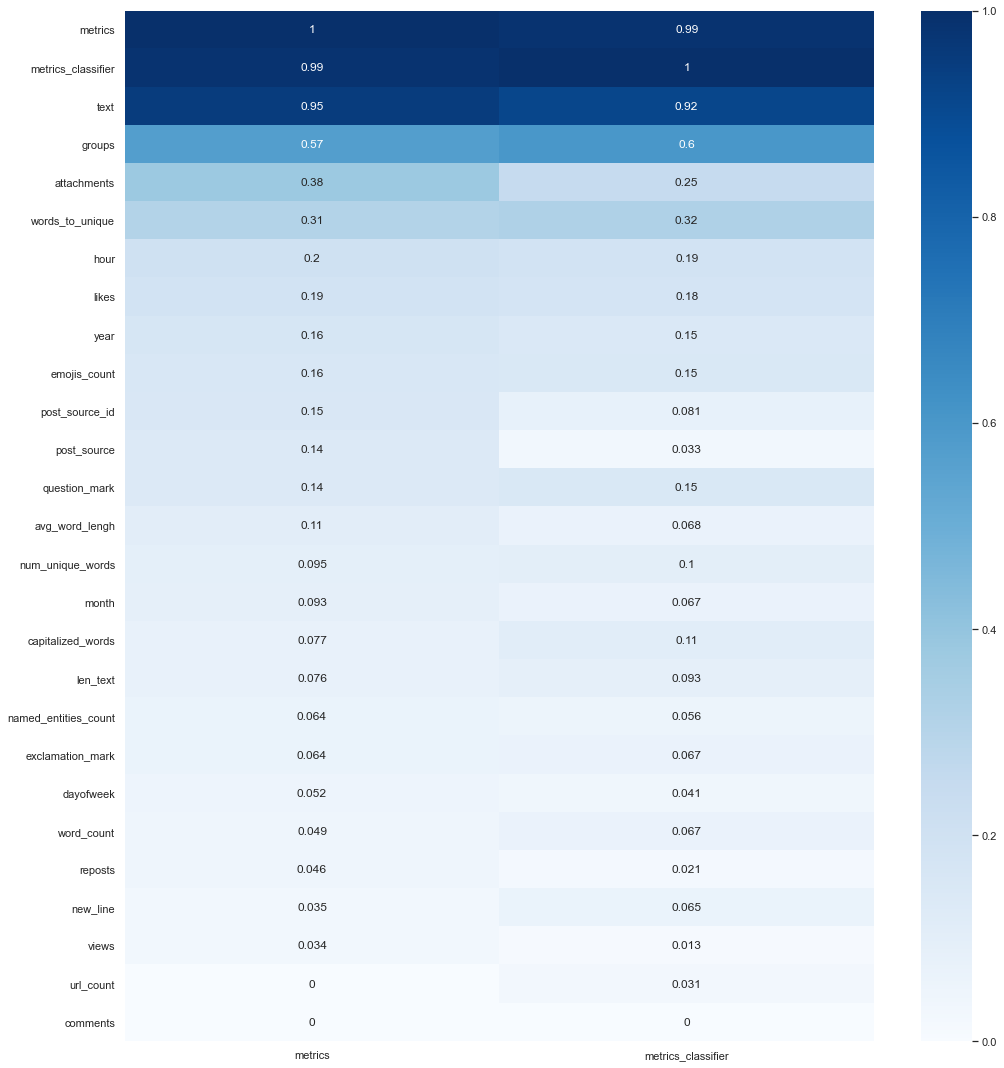

In [19]:
sns.heatmap(vk.drop('pos_tags', axis=1).phik_matrix()[['metrics', 'metrics_classifier']].\
            sort_values(by='metrics', ascending=False), annot=True, cmap='Blues')
plt.tight_layout()
plt.show()

Как видим, наши признаки взяты не с пустого места и коррелируют с текстом. Мы возьмем в модели обучения наши новые признаки плюс некоторые старые, которые могут характеризовать пост: `attachments`, `len_text` и `hour`(потому что время публикации поста также важно). Сделаем датасет с признаками, датасет с целевыми признаками для моделей регрессии и для моделей классификации.

In [20]:
vk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9798 entries, 0 to 9797
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   groups                9798 non-null   object 
 1   text                  9798 non-null   object 
 2   attachments           9798 non-null   int64  
 3   post_source           9798 non-null   object 
 4   comments              9798 non-null   int64  
 5   likes                 9798 non-null   int64  
 6   reposts               9798 non-null   int64  
 7   views                 9798 non-null   float64
 8   len_text              9798 non-null   int64  
 9   post_source_id        9798 non-null   int64  
 10  year                  9798 non-null   int64  
 11  month                 9798 non-null   int64  
 12  dayofweek             9798 non-null   int64  
 13  hour                  9798 non-null   int64  
 14  metrics               9798 non-null   float64
 15  metrics_classifier   

# Обучение

## Подготовка признаков

In [21]:
vk.columns

Index(['groups', 'text', 'attachments', 'post_source', 'comments', 'likes',
       'reposts', 'views', 'len_text', 'post_source_id', 'year', 'month',
       'dayofweek', 'hour', 'metrics', 'metrics_classifier',
       'exclamation_mark', 'question_mark', 'pos_tags', 'named_entities_count',
       'url_count', 'word_count', 'new_line', 'avg_word_lengh',
       'capitalized_words', 'emojis_count', 'num_unique_words',
       'words_to_unique'],
      dtype='object')

In [22]:
X, y_reg, y_class = vk[['attachments', 'len_text', 'hour', 'exclamation_mark', 'question_mark', 
             'named_entities_count','url_count', 'word_count', 'new_line', 
              'avg_word_lengh','capitalized_words', 'emojis_count', 
              'num_unique_words', 'words_to_unique']], vk['metrics'], vk['metrics_classifier']
X

,attachments,len_text,hour,exclamation_mark,question_mark,named_entities_count,url_count,word_count,new_line,avg_word_lengh,capitalized_words,emojis_count,num_unique_words,words_to_unique
0,1,167,11,0,1,0,1,18,2,8.278,0,0,18,1.0000
1,1,1350,10,3,0,14,0,174,19,6.638,6,0,153,0.8793
2,1,138,13,0,0,1,1,22,5,5.182,0,4,22,1.0000
3,1,1055,12,3,1,15,1,150,18,5.913,3,4,134,0.8933
4,1,908,11,3,0,5,1,129,11,5.953,7,4,114,0.8837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9793,1,778,11,3,0,10,0,92,7,7.380,1,3,85,0.9239
9794,1,1595,10,0,0,17,0,217,6,6.350,3,0,179,0.8249
9795,2,50,13,0,0,1,0,6,0,7.500,0,0,6,1.0000
9796,1,365,7,0,0,4,0,45,0,7.133,1,0,41,0.9111


In [23]:
#Делим выборки в пропорции 75-25
X_train, X_test, y_train_reg, y_test_reg, y_train_class, y_test_class = \
train_test_split(X, y_reg, y_class, test_size=.25, random_state=RANDOM_STATE)
print(X_train.shape)
print(X_test.shape)

(7348, 14)
(2450, 14)


In [24]:
#Создам пайплайны для обучения
lgbm_pipe_reg = Pipeline([('scaler', RobustScaler()), ('estimator', LGBMRegressor(random_state=RANDOM_STATE))])
lgbm_pipe_class = Pipeline([('scaler', RobustScaler()), ('estimator', LGBMClassifier(random_state=RANDOM_STATE))])
rf_pipe_reg = Pipeline([('scaler', RobustScaler()), ('estimator', RandomForestRegressor(random_state=RANDOM_STATE))])
rf_pipe_class = Pipeline([('scaler', RobustScaler()), ('estimator', RandomForestClassifier(random_state=RANDOM_STATE))])

In [42]:
#Оставлю это здесь для уточнения адекватности модели
y_train_reg.describe()

count    7348.000000
mean        0.022602
std         0.015778
min         0.000000
25%         0.010989
50%         0.019231
75%         0.030474
max         0.080000
Name: metrics, dtype: float64

### Регрессионные модели

#### LightGBM

In [26]:
#Делаем функцию для того, чтобы смотреть на важность признаков
def feature_importances(model, title=None):
    pd.Series(model.steps[1][1].feature_importances_, X_train.columns).nlargest(20).plot(kind='barh', figsize=(10, 10))
    plt.title(f'Важность признаков для модели {title}')
    plt.xlabel('Важность')
    plt.ylabel('Признаки')
    plt.tight_layout()
    plt.show()

In [27]:
def objective(trial):
    params = {
    'estimator__n_estimators' : trial.suggest_int('n_estimators', 100, 500),
    'estimator__max_depth' : trial.suggest_int('max_depth', 5, 15)
    }
    pipeline = lgbm_pipe_reg.set_params(**params)
    pipeline.fit(X_train, y_train_reg)
    
    trial.set_user_attr(key="best_booster", value=pipeline)
    cross_valid = cross_val_score(pipeline, X_train, y_train_reg, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()  
    return ( - cross_valid) ** .5
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study1 = optuna.create_study(direction='minimize', sampler=sampler)
study1.optimize(objective, n_trials=200, callbacks=[callback])
model_lgbm_reg = study1.user_attrs["best_booster"]
print('RMSE:', study1.best_value, 'с параметрами:', study1.best_params)

[I 2023-03-11 17:03:04,059] A new study created in memory with name: no-name-fc52f325-41d4-4bd9-927a-2f69c64a3e80
[I 2023-03-11 17:03:05,248] Trial 0 finished with value: 0.012736550604797541 and parameters: {'n_estimators': 250, 'max_depth': 15}. Best is trial 0 with value: 0.012736550604797541.
[I 2023-03-11 17:03:06,948] Trial 1 finished with value: 0.012858120460854144 and parameters: {'n_estimators': 393, 'max_depth': 11}. Best is trial 0 with value: 0.012736550604797541.
[I 2023-03-11 17:03:07,696] Trial 2 finished with value: 0.01254061880386507 and parameters: {'n_estimators': 162, 'max_depth': 6}. Best is trial 2 with value: 0.01254061880386507.
[I 2023-03-11 17:03:08,282] Trial 3 finished with value: 0.012535974304675674 and parameters: {'n_estimators': 123, 'max_depth': 14}. Best is trial 3 with value: 0.012535974304675674.
[I 2023-03-11 17:03:09,440] Trial 4 finished with value: 0.01278331319096553 and parameters: {'n_estimators': 341, 'max_depth': 12}. Best is trial 3 with

[I 2023-03-11 17:03:34,083] Trial 41 finished with value: 0.012492351575583578 and parameters: {'n_estimators': 100, 'max_depth': 12}. Best is trial 28 with value: 0.012486821582783636.
[I 2023-03-11 17:03:34,473] Trial 42 finished with value: 0.012492351575583578 and parameters: {'n_estimators': 100, 'max_depth': 12}. Best is trial 28 with value: 0.012486821582783636.
[I 2023-03-11 17:03:34,988] Trial 43 finished with value: 0.01252090301070556 and parameters: {'n_estimators': 126, 'max_depth': 13}. Best is trial 28 with value: 0.012486821582783636.
[I 2023-03-11 17:03:35,594] Trial 44 finished with value: 0.012565801978864604 and parameters: {'n_estimators': 154, 'max_depth': 14}. Best is trial 28 with value: 0.012486821582783636.
[I 2023-03-11 17:03:36,052] Trial 45 finished with value: 0.012494871690670558 and parameters: {'n_estimators': 102, 'max_depth': 12}. Best is trial 28 with value: 0.012486821582783636.
[I 2023-03-11 17:03:36,557] Trial 46 finished with value: 0.01251908708

[I 2023-03-11 17:03:58,083] Trial 83 finished with value: 0.012492351575583578 and parameters: {'n_estimators': 100, 'max_depth': 12}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:03:58,569] Trial 84 finished with value: 0.012508756890858092 and parameters: {'n_estimators': 122, 'max_depth': 11}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:03:59,104] Trial 85 finished with value: 0.012528289361998304 and parameters: {'n_estimators': 135, 'max_depth': 12}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:03:59,563] Trial 86 finished with value: 0.012492549378555878 and parameters: {'n_estimators': 111, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:00,563] Trial 87 finished with value: 0.012735437628824248 and parameters: {'n_estimators': 298, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:01,084] Trial 88 finished with value: 0.0125106683

[I 2023-03-11 17:04:18,639] Trial 125 finished with value: 0.012492592442075017 and parameters: {'n_estimators': 110, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:19,148] Trial 126 finished with value: 0.012552985234296172 and parameters: {'n_estimators': 139, 'max_depth': 14}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:19,633] Trial 127 finished with value: 0.012519257594433592 and parameters: {'n_estimators': 129, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:20,204] Trial 128 finished with value: 0.012542817040340958 and parameters: {'n_estimators': 148, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:20,609] Trial 129 finished with value: 0.012509611578569245 and parameters: {'n_estimators': 107, 'max_depth': 14}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:21,067] Trial 130 finished with value: 0.0124

[I 2023-03-11 17:04:39,596] Trial 166 finished with value: 0.012501597882617746 and parameters: {'n_estimators': 101, 'max_depth': 14}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:40,059] Trial 167 finished with value: 0.012483817357412318 and parameters: {'n_estimators': 100, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:40,573] Trial 168 finished with value: 0.012512622365614174 and parameters: {'n_estimators': 122, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:41,014] Trial 169 finished with value: 0.012485553270589807 and parameters: {'n_estimators': 101, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:41,467] Trial 170 finished with value: 0.012496630626246761 and parameters: {'n_estimators': 117, 'max_depth': 13}. Best is trial 72 with value: 0.012483817357412318.
[I 2023-03-11 17:04:41,904] Trial 171 finished with value: 0.0124

RMSE: 0.012483817357412318 с параметрами: {'n_estimators': 100, 'max_depth': 13}


In [28]:
prediction_lgbm_reg = model_lgbm_reg.predict(X_test)
rmse_lgbm_test = (mean_squared_error(y_test_reg, prediction_lgbm_reg)) ** 0.5
print('RMSE test LightGBM: ', rmse_lgbm_test)

RMSE test LightGBM:  0.0125461560660533


#### Random Forest

In [29]:
def objective(trial):
    params = {
    'estimator__criterion' : trial.suggest_categorical('criterion', ['squared_error']),
    'estimator__n_estimators' : trial.suggest_int('n_estimators', 1, 100),
    'estimator__max_depth' : trial.suggest_int('max_depth', 5, 15),
    'estimator__min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20, 2)
    }
    pipeline = rf_pipe_reg.set_params(**params)
    pipeline.fit(X_train, y_train_reg)
    
    trial.set_user_attr(key="best_booster", value=pipeline)
    cross_valid = cross_val_score(pipeline, X_train, y_train_reg, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()  
    return ( - cross_valid) ** .5
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study2 = optuna.create_study(direction='minimize', sampler=sampler)
study2.optimize(objective, n_trials=200, callbacks=[callback])
model_rf_reg = study2.user_attrs["best_booster"]
print('RMSE:', study2.best_value, 'с параметрами:', study2.best_params)

[I 2023-03-11 17:04:53,637] A new study created in memory with name: no-name-4cecb4b7-a9f0-4cad-804a-b808675feb4d
[I 2023-03-11 17:04:56,251] Trial 0 finished with value: 0.01276506695305649 and parameters: {'criterion': 'squared_error', 'n_estimators': 62, 'max_depth': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.01276506695305649.
[I 2023-03-11 17:04:58,320] Trial 1 finished with value: 0.012594468895325778 and parameters: {'criterion': 'squared_error', 'n_estimators': 37, 'max_depth': 10, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.012594468895325778.
[I 2023-03-11 17:04:59,537] Trial 2 finished with value: 0.012599146275581693 and parameters: {'criterion': 'squared_error', 'n_estimators': 20, 'max_depth': 10, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.012594468895325778.
[I 2023-03-11 17:04:59,992] Trial 3 finished with value: 0.01285599340561955 and parameters: {'criterion': 'squared_error', 'n_estimators': 5, 'max_depth': 11, 'min_samples_leaf':

[I 2023-03-11 17:06:51,314] Trial 33 finished with value: 0.012502799435148697 and parameters: {'criterion': 'squared_error', 'n_estimators': 77, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 26 with value: 0.012484694246976982.
[I 2023-03-11 17:06:55,744] Trial 34 finished with value: 0.012503967378498942 and parameters: {'criterion': 'squared_error', 'n_estimators': 84, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 26 with value: 0.012484694246976982.
[I 2023-03-11 17:06:59,654] Trial 35 finished with value: 0.012573467343926698 and parameters: {'criterion': 'squared_error', 'n_estimators': 93, 'max_depth': 11, 'min_samples_leaf': 18}. Best is trial 26 with value: 0.012484694246976982.
[I 2023-03-11 17:07:04,257] Trial 36 finished with value: 0.01248415659025023 and parameters: {'criterion': 'squared_error', 'n_estimators': 76, 'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.01248415659025023.
[I 2023-03-11 17:07:09,073] Trial 37 finished wit

[I 2023-03-11 17:09:30,235] Trial 66 finished with value: 0.012502183329805936 and parameters: {'criterion': 'squared_error', 'n_estimators': 99, 'max_depth': 13, 'min_samples_leaf': 6}. Best is trial 59 with value: 0.012476496720229933.
[I 2023-03-11 17:09:36,190] Trial 67 finished with value: 0.012499640557486641 and parameters: {'criterion': 'squared_error', 'n_estimators': 81, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 59 with value: 0.012476496720229933.
[I 2023-03-11 17:09:41,754] Trial 68 finished with value: 0.012506090570615887 and parameters: {'criterion': 'squared_error', 'n_estimators': 91, 'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 59 with value: 0.012476496720229933.
[I 2023-03-11 17:09:44,963] Trial 69 finished with value: 0.012503619135733321 and parameters: {'criterion': 'squared_error', 'n_estimators': 50, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 59 with value: 0.012476496720229933.
[I 2023-03-11 17:09:50,908] Trial 70 finished wi

[I 2023-03-11 17:12:14,856] Trial 99 finished with value: 0.012506679908098983 and parameters: {'criterion': 'squared_error', 'n_estimators': 71, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 98 with value: 0.012475147324761666.
[I 2023-03-11 17:12:18,475] Trial 100 finished with value: 0.012500595926415678 and parameters: {'criterion': 'squared_error', 'n_estimators': 83, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 98 with value: 0.012475147324761666.
[I 2023-03-11 17:12:21,975] Trial 101 finished with value: 0.012481769676535885 and parameters: {'criterion': 'squared_error', 'n_estimators': 80, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 98 with value: 0.012475147324761666.
[I 2023-03-11 17:12:24,767] Trial 102 finished with value: 0.01248727464711367 and parameters: {'criterion': 'squared_error', 'n_estimators': 71, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 98 with value: 0.012475147324761666.
[I 2023-03-11 17:12:27,959] Trial 103 finished

[I 2023-03-11 17:14:28,486] Trial 132 finished with value: 0.012474822665985567 and parameters: {'criterion': 'squared_error', 'n_estimators': 77, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:14:32,846] Trial 133 finished with value: 0.012475165012274183 and parameters: {'criterion': 'squared_error', 'n_estimators': 81, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:14:37,027] Trial 134 finished with value: 0.012479663948732903 and parameters: {'criterion': 'squared_error', 'n_estimators': 75, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:14:40,876] Trial 135 finished with value: 0.012487033250652004 and parameters: {'criterion': 'squared_error', 'n_estimators': 77, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:14:44,763] Trial 136 fi

[I 2023-03-11 17:16:30,474] Trial 165 finished with value: 0.012503832798508526 and parameters: {'criterion': 'squared_error', 'n_estimators': 72, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:16:33,966] Trial 166 finished with value: 0.012484723807235908 and parameters: {'criterion': 'squared_error', 'n_estimators': 74, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:16:38,036] Trial 167 finished with value: 0.012477034643837022 and parameters: {'criterion': 'squared_error', 'n_estimators': 82, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:16:41,898] Trial 168 finished with value: 0.012475578101099536 and parameters: {'criterion': 'squared_error', 'n_estimators': 76, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:16:45,278] Trial 169 fi

[I 2023-03-11 17:18:25,526] Trial 198 finished with value: 0.012478445280897157 and parameters: {'criterion': 'squared_error', 'n_estimators': 70, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 109 with value: 0.012472896500750634.
[I 2023-03-11 17:18:28,766] Trial 199 finished with value: 0.01253521037861865 and parameters: {'criterion': 'squared_error', 'n_estimators': 74, 'max_depth': 12, 'min_samples_leaf': 12}. Best is trial 109 with value: 0.012472896500750634.


RMSE: 0.012472896500750634 с параметрами: {'criterion': 'squared_error', 'n_estimators': 74, 'max_depth': 12, 'min_samples_leaf': 4}


In [30]:
prediction_rf_reg = model_rf_reg.predict(X_test)
rmse_rf_test = (mean_squared_error(y_test_reg, prediction_rf_reg)) ** 0.5
print('RMSE test RF: ', rmse_rf_test)

RMSE test RF:  0.012500933190031087


### Модели классификации

In [31]:
#Строим функцию для постройки ROC-AUC графика
def rocauc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
def results(model, features, target):
    prediction = model.predict(features)
    proba_one = model.predict_proba(features)[:, 1]
    fpr, tpr, threshold = roc_curve(target, proba_one)
    rocauc(fpr, tpr)
    print("F1:", round(f1_score(target, prediction), 3))
    print("ROC_auc:", round(roc_auc_score(target, prediction), 3))
    print("Precision:", round(precision_score(target, prediction), 3))
    print("Recall:", round(recall_score(target, prediction), 3))

#### LightGBM

In [32]:
def objective(trial):
    params = {
    'estimator__n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
    'estimator__max_depth' : trial.suggest_int('max_depth', 5, 15)
    }
    pipeline = lgbm_pipe_class.set_params(**params)
    pipeline.fit(X_train, y_train_class)
    
    trial.set_user_attr(key="best_booster", value=pipeline)
    cross_valid = cross_val_score(pipeline, X_train, y_train_class, cv=5, scoring='f1', n_jobs=-1).mean()  
    return cross_valid
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study3 = optuna.create_study(direction='maximize', sampler=sampler)
study3.optimize(objective, n_trials=200, callbacks=[callback])
model_lgbm_class = study3.user_attrs["best_booster"]
print('RMSE:', study3.best_value, 'с параметрами:', study3.best_params)

[I 2023-03-11 17:18:28,849] A new study created in memory with name: no-name-f1eb3bd2-8d27-4453-bb12-5303c529966f
[I 2023-03-11 17:18:31,284] Trial 0 finished with value: 0.5541228978219267 and parameters: {'n_estimators': 973, 'max_depth': 13}. Best is trial 0 with value: 0.5541228978219267.
[I 2023-03-11 17:18:33,936] Trial 1 finished with value: 0.551718708206216 and parameters: {'n_estimators': 946, 'max_depth': 14}. Best is trial 0 with value: 0.5541228978219267.
[I 2023-03-11 17:18:35,547] Trial 2 finished with value: 0.5598400425186553 and parameters: {'n_estimators': 638, 'max_depth': 15}. Best is trial 2 with value: 0.5598400425186553.
[I 2023-03-11 17:18:36,013] Trial 3 finished with value: 0.5751195439355039 and parameters: {'n_estimators': 179, 'max_depth': 7}. Best is trial 3 with value: 0.5751195439355039.
[I 2023-03-11 17:18:36,396] Trial 4 finished with value: 0.5718966097031802 and parameters: {'n_estimators': 140, 'max_depth': 8}. Best is trial 3 with value: 0.5751195

[I 2023-03-11 17:19:08,701] Trial 42 finished with value: 0.5764059557010444 and parameters: {'n_estimators': 144, 'max_depth': 14}. Best is trial 31 with value: 0.5797122120548891.
[I 2023-03-11 17:19:09,240] Trial 43 finished with value: 0.5782527992126085 and parameters: {'n_estimators': 210, 'max_depth': 11}. Best is trial 31 with value: 0.5797122120548891.
[I 2023-03-11 17:19:10,088] Trial 44 finished with value: 0.5742291154102536 and parameters: {'n_estimators': 328, 'max_depth': 11}. Best is trial 31 with value: 0.5797122120548891.
[I 2023-03-11 17:19:10,629] Trial 45 finished with value: 0.5741147524723608 and parameters: {'n_estimators': 193, 'max_depth': 10}. Best is trial 31 with value: 0.5797122120548891.
[I 2023-03-11 17:19:11,293] Trial 46 finished with value: 0.5732705970620282 and parameters: {'n_estimators': 253, 'max_depth': 12}. Best is trial 31 with value: 0.5797122120548891.
[I 2023-03-11 17:19:12,023] Trial 47 finished with value: 0.5737910001551365 and parameter

[I 2023-03-11 17:19:37,982] Trial 85 finished with value: 0.5755221085241047 and parameters: {'n_estimators': 201, 'max_depth': 10}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:19:38,552] Trial 86 finished with value: 0.5714656990384906 and parameters: {'n_estimators': 231, 'max_depth': 9}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:19:39,444] Trial 87 finished with value: 0.5672026431449144 and parameters: {'n_estimators': 351, 'max_depth': 12}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:19:40,205] Trial 88 finished with value: 0.5674658879877181 and parameters: {'n_estimators': 305, 'max_depth': 10}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:19:40,660] Trial 89 finished with value: 0.5802009104725016 and parameters: {'n_estimators': 203, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:19:41,042] Trial 90 finished with value: 0.5765325619853007 and parameters: {'n

[I 2023-03-11 17:20:06,016] Trial 128 finished with value: 0.5654112201182108 and parameters: {'n_estimators': 447, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:06,556] Trial 129 finished with value: 0.5746514765608993 and parameters: {'n_estimators': 197, 'max_depth': 10}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:07,270] Trial 130 finished with value: 0.5754715713672696 and parameters: {'n_estimators': 249, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:07,906] Trial 131 finished with value: 0.5788272586484366 and parameters: {'n_estimators': 215, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:08,509] Trial 132 finished with value: 0.5768565265088256 and parameters: {'n_estimators': 230, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:08,965] Trial 133 finished with value: 0.5735390462791607 and paramete

[I 2023-03-11 17:20:28,752] Trial 171 finished with value: 0.5815650158879813 and parameters: {'n_estimators': 200, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:29,266] Trial 172 finished with value: 0.5794628126024859 and parameters: {'n_estimators': 189, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:29,723] Trial 173 finished with value: 0.5739789985016216 and parameters: {'n_estimators': 173, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:30,243] Trial 174 finished with value: 0.5805136238521874 and parameters: {'n_estimators': 201, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:30,807] Trial 175 finished with value: 0.5788760224247633 and parameters: {'n_estimators': 226, 'max_depth': 11}. Best is trial 71 with value: 0.582105587465795.
[I 2023-03-11 17:20:31,219] Trial 176 finished with value: 0.5777556353924892 and paramete

RMSE: 0.582105587465795 с параметрами: {'n_estimators': 199, 'max_depth': 11}


In [33]:
prediction_lgbm_class = model_lgbm_class.predict(X_test)
f1_lgbm_test = f1_score(y_test_class, prediction_lgbm_class)
print('F1 test LightGBM: ', f1_lgbm_test)

F1 test LightGBM:  0.5823754789272031


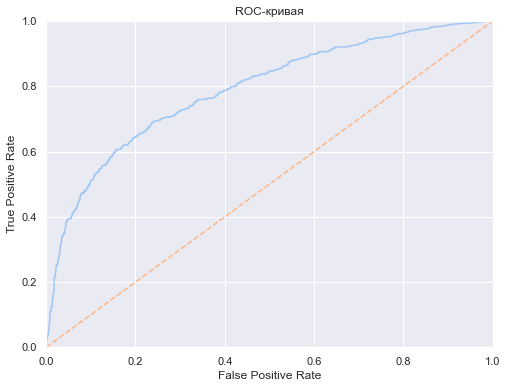

F1: 0.582
ROC_auc: 0.701
Precision: 0.695
Recall: 0.501


In [34]:
results(model_lgbm_class, X_test, y_test_class)

#### Random Forest

In [35]:
def objective(trial):
    params = {
    'estimator__criterion' : trial.suggest_categorical('criterion', ['entropy']),
    'estimator__n_estimators' : trial.suggest_int('n_estimators', 1, 100),
    'estimator__max_depth' : trial.suggest_int('max_depth', 5, 15),
    'estimator__min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20, 2)
    }
    pipeline = rf_pipe_class.set_params(**params)
    pipeline.fit(X_train, y_train_class)
    
    trial.set_user_attr(key="best_booster", value=pipeline)
    cross_valid = cross_val_score(pipeline, X_train, y_train_class, cv=5, scoring='f1', n_jobs=-1).mean()  
    return cross_valid
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study4 = optuna.create_study(direction='maximize', sampler=sampler)
study4.optimize(objective, n_trials=200, callbacks=[callback])
model_rf_class = study4.user_attrs["best_booster"]
print('F1:', study4.best_value, 'с параметрами:', study4.best_params)

[I 2023-03-11 17:20:43,544] A new study created in memory with name: no-name-a29ec659-64bf-441a-9d92-90d6207f0888
[I 2023-03-11 17:20:44,568] Trial 0 finished with value: 0.5521478343961468 and parameters: {'criterion': 'entropy', 'n_estimators': 78, 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5521478343961468.
[I 2023-03-11 17:20:45,867] Trial 1 finished with value: 0.5449942239786713 and parameters: {'criterion': 'entropy', 'n_estimators': 82, 'max_depth': 12, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.5521478343961468.
[I 2023-03-11 17:20:46,661] Trial 2 finished with value: 0.5416110806043545 and parameters: {'criterion': 'entropy', 'n_estimators': 78, 'max_depth': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5521478343961468.
[I 2023-03-11 17:20:46,907] Trial 3 finished with value: 0.5358672692886449 and parameters: {'criterion': 'entropy', 'n_estimators': 12, 'max_depth': 14, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.

[I 2023-03-11 17:21:19,221] Trial 34 finished with value: 0.5549965996444681 and parameters: {'criterion': 'entropy', 'n_estimators': 84, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.5594391113248124.
[I 2023-03-11 17:21:20,744] Trial 35 finished with value: 0.5490616277715901 and parameters: {'criterion': 'entropy', 'n_estimators': 92, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 33 with value: 0.5594391113248124.
[I 2023-03-11 17:21:21,975] Trial 36 finished with value: 0.5441757144165951 and parameters: {'criterion': 'entropy', 'n_estimators': 77, 'max_depth': 12, 'min_samples_leaf': 18}. Best is trial 33 with value: 0.5594391113248124.
[I 2023-03-11 17:21:23,151] Trial 37 finished with value: 0.560722135857991 and parameters: {'criterion': 'entropy', 'n_estimators': 69, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 37 with value: 0.560722135857991.
[I 2023-03-11 17:21:23,220] Trial 38 finished with value: 0.5196245819093244 and parameter

[I 2023-03-11 17:21:55,741] Trial 69 finished with value: 0.5510817599064805 and parameters: {'criterion': 'entropy', 'n_estimators': 50, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 42 with value: 0.5611718567964846.
[I 2023-03-11 17:21:56,812] Trial 70 finished with value: 0.5561013872100602 and parameters: {'criterion': 'entropy', 'n_estimators': 61, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 42 with value: 0.5611718567964846.
[I 2023-03-11 17:21:57,919] Trial 71 finished with value: 0.5577223330416192 and parameters: {'criterion': 'entropy', 'n_estimators': 64, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 42 with value: 0.5611718567964846.
[I 2023-03-11 17:21:59,205] Trial 72 finished with value: 0.5597303167642151 and parameters: {'criterion': 'entropy', 'n_estimators': 74, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 42 with value: 0.5611718567964846.
[I 2023-03-11 17:22:00,397] Trial 73 finished with value: 0.5595300908543349 and paramet

[I 2023-03-11 17:22:41,743] Trial 104 finished with value: 0.562441688384552 and parameters: {'criterion': 'entropy', 'n_estimators': 84, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 104 with value: 0.562441688384552.
[I 2023-03-11 17:22:43,613] Trial 105 finished with value: 0.5621973602680951 and parameters: {'criterion': 'entropy', 'n_estimators': 84, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 104 with value: 0.562441688384552.
[I 2023-03-11 17:22:44,971] Trial 106 finished with value: 0.5558376155264246 and parameters: {'criterion': 'entropy', 'n_estimators': 92, 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 104 with value: 0.562441688384552.
[I 2023-03-11 17:22:46,762] Trial 107 finished with value: 0.5598431527211611 and parameters: {'criterion': 'entropy', 'n_estimators': 84, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 104 with value: 0.562441688384552.
[I 2023-03-11 17:22:48,263] Trial 108 finished with value: 0.545500889677158 and parame

[I 2023-03-11 17:23:26,502] Trial 138 finished with value: 0.5582336682201365 and parameters: {'criterion': 'entropy', 'n_estimators': 83, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 104 with value: 0.562441688384552.
[I 2023-03-11 17:23:27,742] Trial 139 finished with value: 0.5568679303002391 and parameters: {'criterion': 'entropy', 'n_estimators': 80, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 104 with value: 0.562441688384552.
[I 2023-03-11 17:23:29,134] Trial 140 finished with value: 0.5609852961997123 and parameters: {'criterion': 'entropy', 'n_estimators': 87, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 104 with value: 0.562441688384552.
[I 2023-03-11 17:23:30,477] Trial 141 finished with value: 0.5613185780700568 and parameters: {'criterion': 'entropy', 'n_estimators': 85, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 104 with value: 0.562441688384552.
[I 2023-03-11 17:23:31,844] Trial 142 finished with value: 0.5613185780700568 and param

[I 2023-03-11 17:24:15,294] Trial 172 finished with value: 0.5610016717350458 and parameters: {'criterion': 'entropy', 'n_estimators': 98, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 167 with value: 0.5639470534541926.
[I 2023-03-11 17:24:16,985] Trial 173 finished with value: 0.5625463511638706 and parameters: {'criterion': 'entropy', 'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 167 with value: 0.5639470534541926.
[I 2023-03-11 17:24:18,664] Trial 174 finished with value: 0.5625463511638706 and parameters: {'criterion': 'entropy', 'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 167 with value: 0.5639470534541926.
[I 2023-03-11 17:24:20,355] Trial 175 finished with value: 0.5625463511638706 and parameters: {'criterion': 'entropy', 'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 167 with value: 0.5639470534541926.
[I 2023-03-11 17:24:22,005] Trial 176 finished with value: 0.5639470534541926

F1: 0.5639470534541926 с параметрами: {'criterion': 'entropy', 'n_estimators': 99, 'max_depth': 15, 'min_samples_leaf': 2}


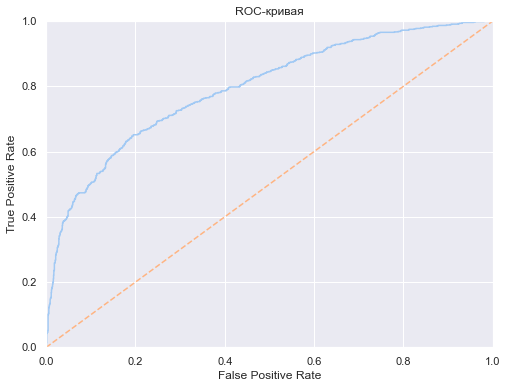

F1: 0.576
ROC_auc: 0.699
Precision: 0.756
Recall: 0.466


In [36]:
results(model_rf_class, X_test, y_test_class)

In [37]:
prediction_rf_class = model_rf_class.predict(X_test)
f1_rf_test = f1_score(y_test_class, prediction_rf_class)
print('F1 test RF: ', f1_rf_test)

F1 test RF:  0.576326530612245


# Итоги

Мы обучили модели, давайте сведем результаты в таблицы.

In [38]:
metric_table = pd.DataFrame(data=[
    (round(study1.best_value, 7), round(rmse_lgbm_test, 7)),
    (round(study2.best_value, 7), round(rmse_rf_test, 7))
], index=['LightGBM', 'RandomForest'], columns=['RMSE on CV', 'RMSE on Test'])

display(metric_table)

,RMSE on CV,RMSE on Test
LightGBM,0.012484,0.012546
RandomForest,0.012473,0.012501


In [39]:
metric_table2 = pd.DataFrame(data=[
    (round(study3.best_value, 3), round(f1_lgbm_test, 3)),
    (round(study4.best_value, 3), round(f1_rf_test, 3))
], index=['LightGBM', 'RandomForest'], columns=['F1 on CV', 'F1 on Test'])

display(metric_table2)

,F1 on CV,F1 on Test
LightGBM,0.582,0.582
RandomForest,0.564,0.576


В первом случае для сравнения весов признаков отберем RandomForestRegressor, во-втором - LightGBM Classifier, тк при адекватности всех моделей, метрики у них лучше.

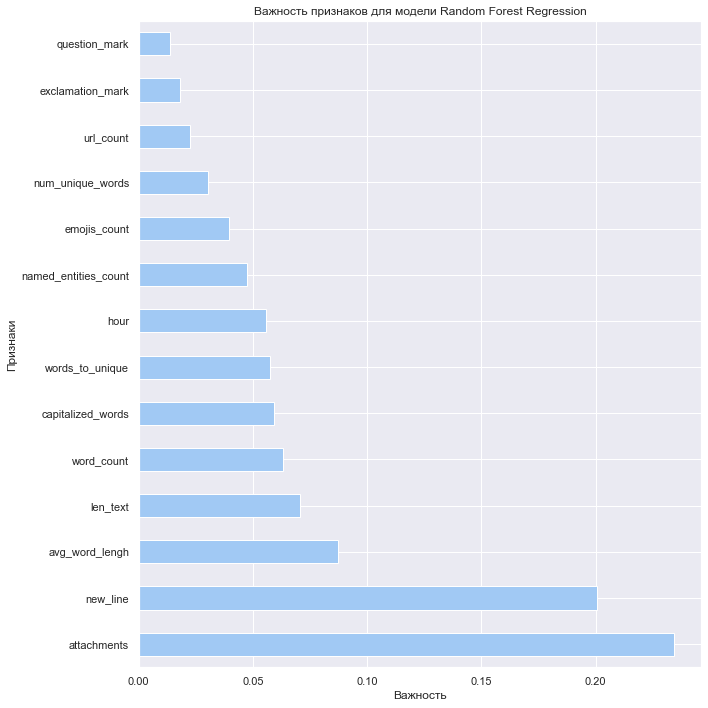

In [40]:
feature_importances(model_rf_reg, 'Random Forest Regression')

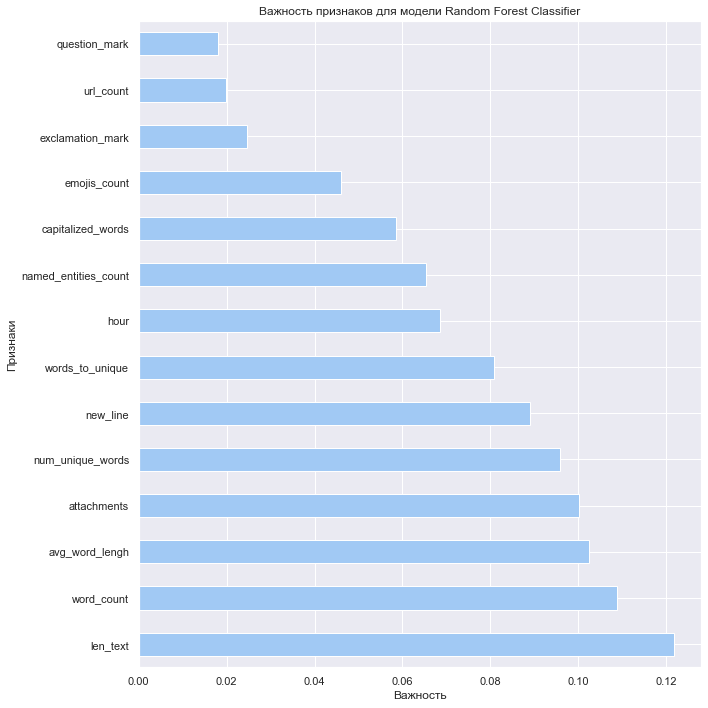

In [41]:
feature_importances(model_rf_class, 'Random Forest Classifier')

**Вывод:** 

- Как мы видим, топ признаков у двух моделей регрессии и классификации разный.
- При утверждении результатов предпочтение отдавать будем модели классификации, тк она выдает хороший результат почти на уровне F1 = 0.6, и Precision = 0,725 тогда как регрессия выдает в среднем RMSE = 0,155 при стандартном отклонении 0,186.
- Предварительно можно сделать вывод, что знаки препинания, эмодзи, URL в целом роли не играют.
- Но мы отчетливо видим, что обе модели достаточно высоко оценивают среднюю длину слов, разнообразие словарного запаса (причем не общее количество уникальных слов, а именно разнообразие по отношению к тексту), количество абзацев и длину текста.
- Модель классификации также оценила достаточно высоко нахождение в тексте именных сущностей, упоминание топонимов и знаменитостей.
- Обе модели высоко оценили влияние вложений на популярность поста. Думаю, этот признак также важен.
- В совокупности с итогами первой работы, можем составить общий портрет популярного поста в соцсетях.